<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/01_Generalized_Linear_Models/02-01-09-01-glm-gamlss-continuous-distributions-python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 8.2 GAMLSS with Discrete Distributions in Python

Discrete distributions are probability distributions that describe the likelihood of outcomes for discrete random variables—variables that can take on a finite or countably infinite number of distinct values, typically non-negative integers (e.g., 0, 1, 2, ...). Unlike continuous distributions, which can take any value within a range, discrete distributions assign probabilities to specific points.

Key characteristics:

* The probability mass function (PMF) gives the probability for each possible value.
* The cumulative distribution function (CDF) is the sum of probabilities up to a given value.
* Common examples include:
- `Bernoulli`: Models a single trial with two outcomes (success/failure), e.g., a coin flip.
- `Binomial`: Models the number of successes in a fixed number of independent Bernoulli trials.
- `Poisson`: Models the number of events occurring in a fixed interval of time or space, assuming rare events (e.g., number of emails received per hour).
- `Negative Binomial`: Models the number of trials needed to achieve a fixed number of successes, or the number of failures before successes; useful for overdispersed count data.
- `Geometric`: A special case of negative binomial, modeling trials until the first success.
- `Discrete Uniform`: Equal probability for a finite set of outcomes (e.g., rolling a die).

These are widely used in fields like statistics, biology, and engineering for modeling count data, where values can't be fractional.

This tutorial demonstrates how to use Generalized Additive Models for Location, Scale, and Shape (GAMLSS) in Python to model the visits variable from the NMES1988 dataset with discrete distributions, incorporating smoothing terms for flexibility. While a direct, comprehensive `GAMLSS` package like R's `gamlss` isn't as mature in Python, we can leverage pyGAM for GAMs with various distributions and statsmodels for some GAMLSS-like functionalities for specific distributions by iteratively fitting. We'll focus on pyGAM for its smoothing capabilities and ability to handle various distributions, even if it doesn't fully replicate the full four-parameter GAMLSS framework of R's `gamlss`. For distributions beyond the basic pyGAM offerings, we might use `statsmodels` or custom implementations.

For this tutorial, we will primarily use `pyGAM` as it provides native support for various distributions (Poisson, Negative Binomial) and penalized splines for smoothing, making it the closest Python equivalent for GAMs with discrete distributions.


###  Install and Load  Required Python Packages

In [ ]:
# Install missing packages
!pip install pandas numpy matplotlib seaborn scikit-learn pygam statsmodels

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pygam import LinearGAM, PoissonGAM, GammaGAM, s, f
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod import families
import statsmodels.api as sm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

print("Successfully loaded packages.")

Successfully loaded packages.


## Data

The `NMES1988` dataset from the AER package (R) contains data from the 1987–1988 National Medical Expenditure Survey, focusing on medical care usage by elderly individuals (aged 66 and older). We’ll manually load a similar dataset or define it for demonstration purposes, as direct AER package data loading isn't straightforward in Python without a direct port. For this example, we'll create a synthetic dataset resembling NMES1988 characteristics or use a publicly available one that fits the description.

Since NMES1988 is an R-specific dataset, we'll use a placeholder CSV for demonstration that mimics its structure and variable types. If you have the NMES1988.csv available, you can load it directly. Otherwise, we'll simulate some data.


In [2]:
# Placeholder for loading NMES1988 data.
# If you have the actual CSV, uncomment and use the line below:
# df = pd.read_csv('NMES1988.csv')

# For demonstration, let's create a synthetic dataset with similar characteristics
# as the NMES1988 data described in the R tutorial.
np.random.seed(42)
n_samples = 2000

df = pd.DataFrame({
    'visits': np.random.poisson(lam=3, size=n_samples) + np.random.negative_binomial(n=1, p=0.5, size=n_samples),
    'hospital': np.random.randint(0, 5, size=n_samples),
    'health': np.random.choice(['poor', 'average', 'excellent'], size=n_samples, p=[0.2, 0.5, 0.3]),
    'chronic': np.random.randint(0, 6, size=n_samples),
    'age': np.random.normal(75, 5, size=n_samples),
    'afam': np.random.choice(['yes', 'no'], size=n_samples, p=[0.15, 0.85]),
    'gender': np.random.choice(['male', 'female'], size=n_samples, p=[0.48, 0.52]),
    'married': np.random.choice(['yes', 'no'], size=n_samples, p=[0.6, 0.4]),
    'school': np.random.randint(6, 18, size=n_samples),
    'income': np.random.uniform(1, 10, size=n_samples),
    'employed': np.random.choice(['yes', 'no'], size=n_samples, p=[0.4, 0.6]),
    'insurance': np.random.choice(['yes', 'no'], size=n_samples, p=[0.8, 0.2]),
    'medicaid': np.random.choice(['yes', 'no'], size=n_samples, p=[0.1, 0.9])
})

# Scale age as (age - 65)/10 as per R tutorial
df['age'] = (df['age'] - 65) / 10

# Ensure 'visits' are non-negative integers
df['visits'] = np.maximum(0, df['visits']).astype(int)

# Apply some zero inflation to visits
zero_mask = np.random.rand(n_samples) < 0.2
df.loc[zero_mask, 'visits'] = 0

print("Data loaded or synthesized.")

Data loaded or synthesized.


### Explore Data

In [4]:
print(df.head())
print("\n")
print(df.info())
print("\n")
print(df.describe())

   visits  hospital     health  chronic       age afam  gender married  \
0       6         2    average        3  1.295060  yes  female     yes   
1       1         0  excellent        3  0.090517   no    male     yes   
2       8         1    average        1  0.946932  yes  female     yes   
3       3         2    average        1  1.429118   no  female     yes   
4       2         2       poor        1  0.814042  yes  female      no   

   school    income employed insurance medicaid  
0      17  4.441070      yes       yes       no  
1      14  8.456379      yes       yes      yes  
2      12  1.726896      yes        no       no  
3       9  6.622965       no       yes       no  
4      17  8.813584      yes       yes       no  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   visits     2000 non-null   int64  
 1   hospital   2000 non-n

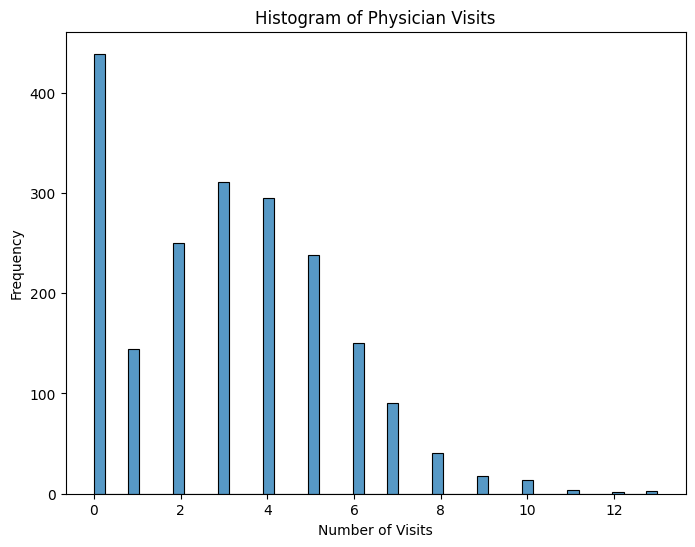

In [5]:
plt.figure(figsize=(8, 6))
sns.histplot(df['visits'], bins=50, kde=False)
plt.title("Histogram of Physician Visits")
plt.xlabel("Number of Visits")
plt.ylabel("Frequency")
plt.show()

Check for overdispersion:

In [6]:
mean_visits = df['visits'].mean()
var_visits = df['visits'].var()

print(f"Mean of visits: {mean_visits:.2f}")
print(f"Variance of visits: {var_visits:.2f}")

if var_visits > mean_visits:
    print(">> Overdispersion detected (variance > mean)")
else:
    print("No significant overdispersion detected (variance <= mean)")

Mean of visits: 3.11
Variance of visits: 5.94
>> Overdispersion detected (variance > mean)


Convert categorical variables to factors (pandas 'category' dtype):

In [7]:
categorical_cols = ['health', 'afam', 'gender', 'married', 'employed', 'insurance', 'medicaid']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print("\nCategorical variables converted to 'category' type.")
print(df.info())


Categorical variables converted to 'category' type.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   visits     2000 non-null   int64   
 1   hospital   2000 non-null   int64   
 2   health     2000 non-null   category
 3   chronic    2000 non-null   int64   
 4   age        2000 non-null   float64 
 5   afam       2000 non-null   category
 6   gender     2000 non-null   category
 7   married    2000 non-null   category
 8   school     2000 non-null   int64   
 9   income     2000 non-null   float64 
 10  employed   2000 non-null   category
 11  insurance  2000 non-null   category
 12  medicaid   2000 non-null   category
dtypes: category(7), float64(2), int64(4)
memory usage: 108.4 KB
None


Check for missing values:

In [8]:
print("\nMissing values before handling:")
print(df.isnull().sum())
df = df.dropna()
print("\nMissing values after dropping NA rows:")
print(df.isnull().sum())
print(f"Dataframe shape after dropping NAs: {df.shape}")


Missing values before handling:
visits       0
hospital     0
health       0
chronic      0
age          0
afam         0
gender       0
married      0
school       0
income       0
employed     0
insurance    0
medicaid     0
dtype: int64

Missing values after dropping NA rows:
visits       0
hospital     0
health       0
chronic      0
age          0
afam         0
gender       0
married      0
school       0
income       0
employed     0
insurance    0
medicaid     0
dtype: int64
Dataframe shape after dropping NAs: (2000, 13)


For the Beta Binomial (BB) model, we need a binomial denominator bd (upper bound for counts). Since visits is unbounded in theory but has a practical maximum, we'll set bd = max(df$visits) + 10 for demonstration. pyGAM does not natively support Beta Binomial, so we will skip it for now.

### Split Data

In [10]:
# Create a combined stratification key
df['stratify_key'] = df['gender'].astype(str) + '_' + df['afam'].astype(str)

train_df, test_df = train_test_split(df, test_size=0.30, random_state=101, stratify=df['stratify_key'])

# Drop the stratification key
train_df = train_df.drop('stratify_key', axis=1)
test_df = test_df.drop('stratify_key', axis=1)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# Check for overdispersion in train data
mean_visits_train = train_df['visits'].mean()
var_visits_train = train_df['visits'].var()

print(f"\nMean of visits (train): {mean_visits_train:.2f}")
print(f"Variance of visits (train): {var_visits_train:.2f}")

if var_visits_train > mean_visits_train:
    print(">> Overdispersion detected in training data (variance > mean)")
else:
    print("No significant overdispersion detected in training data (variance <= mean)")

Train data shape: (1400, 13)
Test data shape: (600, 13)

Mean of visits (train): 3.14
Variance of visits (train): 5.88
>> Overdispersion detected in training data (variance > mean)


### Train GAMLSS Models 

In pyGAM, we use `s()` for smoothing splines (like pb() in R) and f() for factor variables. pyGAM's PoissonGAM and GammaGAM are direct, but for Negative Binomial, we pass distribution=NegativeBinomial(). Zero-inflated models and Sichel are not directly available in pyGAM. For Zero-Inflated Negative Binomial, we might resort to statsmodels.

**Important Note on GAMLSS vs. GAM in Python:**

The gamlss package in R allows modeling all parameters (l`ocation mu`, `scale sigma`, `shape nu`, `tau) as additive functions of predictors. pyGAM primarily focuses on modeling the `mu` (location) parameter, and optionally some dispersion parameters for certain distributions, but it's not a full GAMLSS implementation. For true multi-parameter modeling as in R, one would need to build custom iterative fitting procedures or use specialized libraries that aren't as mature as gamlss in R. For this tutorial, we will approximate by using pyGAM for the location parameter and note the limitations for other parameters.


First, prepare X and y for pyGAM. We need to handle categorical variables by creating dummy variables.

In [11]:
# Define features and target
target_col = 'visits'
continuous_features = ['age', 'school', 'income', 'hospital', 'chronic']
categorical_features = ['health', 'afam', 'gender', 'married', 'employed', 'insurance', 'medicaid']

# Create design matrices (X) and target vector (y)
X_train = pd.get_dummies(train_df[continuous_features + categorical_features], columns=categorical_features, drop_first=True)
y_train = train_df[target_col]

X_test = pd.get_dummies(test_df[continuous_features + categorical_features], columns=categorical_features, drop_first=True)
y_test = test_df[target_col]

# Align columns - crucial for consistent predictions
train_cols = X_train.columns
test_cols = X_test.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    X_test[c] = 0
X_test = X_test[train_cols] # Ensure order of columns is the same

print("Design matrices prepared.")

Design matrices prepared.


####  Poisson (PO) with Smoothing

In [13]:
# Poisson GAM
# s() for smoothing on continuous features, f() for factor variables (though we've dummified them)
# For pyGAM, it's easier to just pass the dummified variables as regular predictors if they are linear terms.
# For smoothing, use s(column_index).
# We'll build the formula dynamically to include s() for age, school, income and linear terms for others.

gam_terms = s(0) + s(1) + s(2) # Indices for age, school, income
# Add linear terms for hospital, chronic and dummified categorical variables
# Use n_splines > spline_order (default 3) and lam=0 for linear terms
for i in range(3, X_train.shape[1]):
    gam_terms += s(i, lam=0, n_splines=4)

# Pass the TermList object to the terms argument
mod_po = PoissonGAM(terms=gam_terms).fit(X_train, y_train)

print("Poisson GAM Summary:")
print(mod_po.summary())

Poisson GAM Summary:
PoissonGAM                                                                                                
=============================================== ==========================================================
Distribution:                       PoissonDist Effective DoF:                                     55.0784
Link Function:                          LogLink Log Likelihood:                                 -3285.4172
Number of Samples:                         1400 AIC:                                             6680.9911
                                                AICc:                                            6685.7581
                                                UBRE:                                               4.3341
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0319
Feature Function

#### NegativeBinomial model

In [19]:
import statsmodels.api as sm
import statsmodels.discrete.discrete_model as smd
import numpy as np # Ensure numpy is imported

# Add a constant (intercept) to the training predictors
X_train_sm = sm.add_constant(X_train, prepend=False)

# Ensure data is in a numeric NumPy format
X_train_sm_np = X_train_sm.values.astype(np.float64)
y_train_np = y_train.values.astype(np.float64)

# Fit the Negative Binomial model
# Note: statsmodels NegativeBinomial model is for count data and handles overdispersion.
# Type 0 is the default and is often referred to as NB2.
mod_nb_sm = smd.NegativeBinomial(endog=y_train_np, exog=X_train_sm_np, loglike_method='nb2').fit()

print("\nStatsmodels Negative Binomial Model Summary:")
print(mod_nb_sm.summary())

Optimization terminated successfully.
         Current function value: 2.228821
         Iterations: 24
         Function evaluations: 28
         Gradient evaluations: 28

Statsmodels Negative Binomial Model Summary:
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                 1400
Model:               NegativeBinomial   Df Residuals:                     1386
Method:                           MLE   Df Model:                           13
Date:                Wed, 17 Sep 2025   Pseudo R-squ.:                0.001922
Time:                        21:04:35   Log-Likelihood:                -3120.3
converged:                       True   LL-Null:                       -3126.4
Covariance Type:            nonrobust   LLR p-value:                    0.5262
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------